In [2]:
import numpy as np
import pandas as pd

# This class assumes future contracts for one and only one underlying asset.
class MarketSimulation:
    def __init__(self, spot_price, start_date, contract_list=[3,6,9] ,variance=0.5):
        self.spot_price = spot_price
        self.variance = variance
        # number_of_data_points = data_size
        self.start_date = start_date
        # self.bids = self.generate_bids_asks(direction='bid')
        # self.asks = self.generate_bids_asks(direction='ask')
        # self.spot,self.bids,self.asks, self.dates = self.generate_bids_asks()

        columns = ['Date','Spot Price','Bid Price','Bid Quantity','Ask Price','Ask Quantity',]

        self.order_book_df ={}
        self.order_book_json ={}

        for contract_length in contract_list:
            length_days = contract_length * 30
            # We are making the dataset with hour granularity
            data_size = length_days * 24
            current_order_book_df = pd.DataFrame(data = self.generate_bids_asks(data_size)).transpose()
            current_order_book_df.columns = columns
            self.order_book_df.update( { str(contract_length) + "M" : current_order_book_df } )
            # We create the json object and append it to it's dict
            self.order_book_json.update( {(str(contract_length) + "M") : current_order_book_df.to_json(orient='records') } ) 

    def generate_bids_asks(self, number_of_data_points):
        # Generate price levels using a normal distribution
        price_levels = np.random.normal(self.spot_price, self.variance, number_of_data_points+1)
        
        # Ensure all price levels are positive and sorted in different directions for bids/asks
        price_levels = np.abs(price_levels)  # To avoid negative prices

        # Making synthetic prices for the market. Spot prices follow normal distribution. Bids for futures are a random percentage lower and asks a random percentage higher.
        spot = price_levels
        bids =  price_levels - ( price_levels * np.random.uniform(0.005, 0.01) )
        asks =  price_levels + ( price_levels * np.random.uniform(0.005, 0.01) )

        # We calculate some quantities for each bid ask
        bid_quantities = np.random.randint(1, 10, size=number_of_data_points+1)  # Random quantity for bids
        ask_quantities = np.random.randint(1, 10, size=number_of_data_points+1)  # Double the quantity for asks
        # We'll generate synthetic date times with hour granularity, given as parameters for the class
        dates = pd.date_range(start=self.start_date, periods=number_of_data_points+1, freq="H")
        return dates,spot,bids, bid_quantities,asks, ask_quantities

# Instantiate the MarketSimulation with a base price (e.g., today's price of soy)
market_simulation = MarketSimulation(spot_price=10, start_date="2024-12-01 00:00:00", contract_list=[3,6,9], variance = 0.5)

# Get the order book DataFrame
market_simulation.order_book_df["3M"]
# order_book_df = market_simulation.order_book_df["3M"]
# market_simulation.order_book_json
#### COLOCAR EL NOMBRE DE LAS COLUMNAS

,Date,Spot Price,Bid Price,Bid Quantity,Ask Price,Ask Quantity
0,2024-12-01 00:00:00,10.154213,10.062128,9,10.237139,8
1,2024-12-01 01:00:00,10.463253,10.368365,4,10.548702,9
2,2024-12-01 02:00:00,11.004566,10.904768,8,11.094435,4
3,2024-12-01 03:00:00,10.663135,10.566434,6,10.750216,6
4,2024-12-01 04:00:00,10.299967,10.20656,7,10.384083,3
...,...,...,...,...,...,...
2156,2025-02-28 20:00:00,10.238717,10.145865,7,10.322333,6
2157,2025-02-28 21:00:00,9.947623,9.857411,3,10.028862,1
2158,2025-02-28 22:00:00,9.975278,9.884816,9,10.056743,8
2159,2025-02-28 23:00:00,10.312187,10.218669,1,10.396402,2


### Let's visualize bids and asks to make sure they are gaussian and in correct quantities

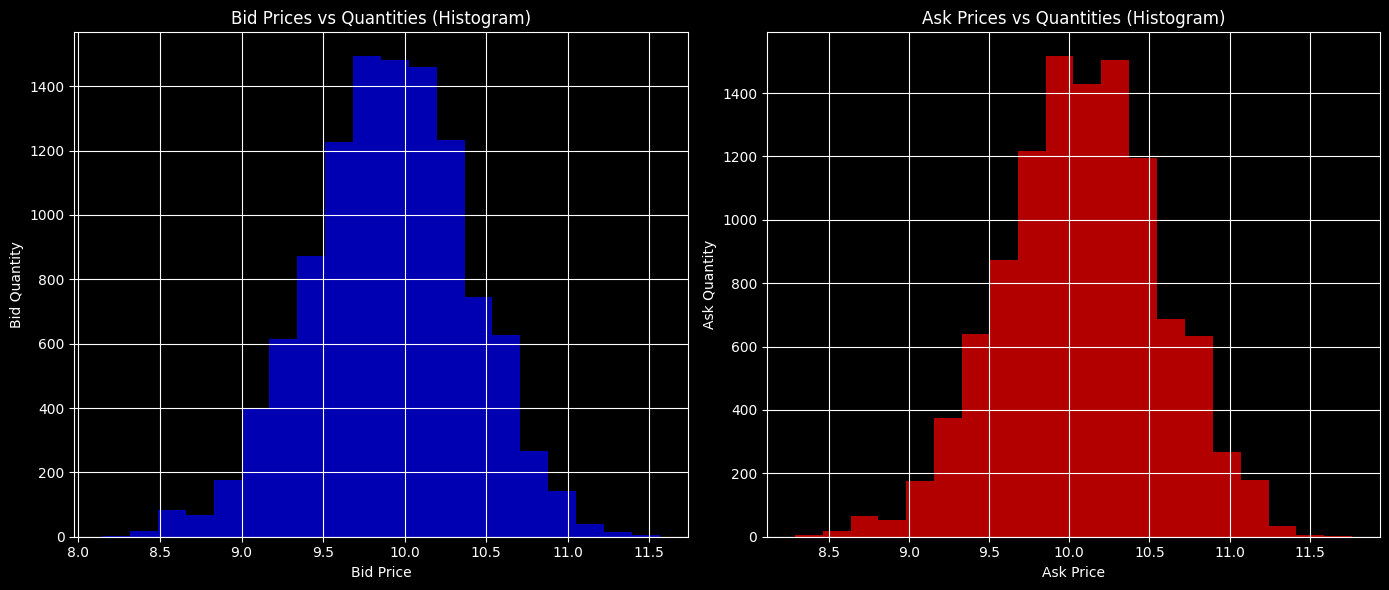

In [3]:
import matplotlib.pyplot as plt

# Get the order book DataFrame
order_book_df = market_simulation.order_book_df["3M"]

# Create a figure with two subplots for bids and asks
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the histogram for bids with quantities
axs[0].hist(order_book_df['Bid Price'], bins=20, weights=order_book_df['Bid Quantity'], color='blue', alpha=0.7)
axs[0].set_title('Bid Prices vs Quantities (Histogram)')
axs[0].set_xlabel('Bid Price')
axs[0].set_ylabel('Bid Quantity')
axs[0].grid(True)

# Plot the histogram for asks with quantities
axs[1].hist(order_book_df['Ask Price'], bins=20, weights=order_book_df['Ask Quantity'], color='red', alpha=0.7)
axs[1].set_title('Ask Prices vs Quantities (Histogram)')
axs[1].set_xlabel('Ask Price')
axs[1].set_ylabel('Ask Quantity')
axs[1].grid(True)

# Adjust layout to make it neat
plt.tight_layout()
plt.show()


### Let's have a new component that process this json data and loads it into memory

In [4]:
class MarketDataManager:
    def __init__(self, json_data={}):
        # self.df = pd.read_json(json_data)
        self.df = {}
        for contract_length_str in json_data.keys():
            self.df.update( {contract_length_str: pd.read_json( json_data[contract_length_str]) } ) 
        

# Example usage:
lifted_market_data_dict_of_dfs = MarketDataManager(json_data=market_simulation.order_book_json).df
lifted_market_data_dict_of_dfs["9M"]
# lifted_market_data_df["Date"].dtype

,Date,Spot Price,Bid Price,Bid Quantity,Ask Price,Ask Quantity
0,2024-12-01 00:00:00,9.775339,9.711330,6,9.825702,8
1,2024-12-01 01:00:00,9.416743,9.355083,4,9.465259,4
2,2024-12-01 02:00:00,10.136957,10.070581,8,10.189184,9
3,2024-12-01 03:00:00,10.801301,10.730575,8,10.856950,4
4,2024-12-01 04:00:00,10.415842,10.347639,6,10.469505,8
...,...,...,...,...,...,...
6476,2025-08-27 20:00:00,10.389183,10.321155,8,10.442709,2
6477,2025-08-27 21:00:00,10.950761,10.879056,4,11.007180,5
6478,2025-08-27 22:00:00,10.577417,10.508156,9,10.631913,2
6479,2025-08-27 23:00:00,9.935247,9.870192,1,9.986435,6


In [5]:
class MarketMaker:
    def __init__(self, lifted_market_data_dict_of_dfs, budget = 10000, spread_criteria_proportion=0.25, capital_cost=0.05, ):
        self.market_data_dict_of_dfs = lifted_market_data_dict_of_dfs
        self.market_data_dict_of_jsons = {}
        self.capital_cost = capital_cost
        # current_date="2024-12-01 00:00:00", expiration_date="2025-03-01 00:00:00"
        # self.current_date = pd.to_datetime(current_date)  # Time in hours
        # self.expiration_date = pd.to_datetime(expiration_date)  # Time to maturity in days
        self.budget = budget
        self.spread_criteria_proportion = spread_criteria_proportion

        lifted_market_data_dict_of_dfs

        # We update market_data so it's updated with future prices and corrected bid and asks to post
        # We also create the corresponding json file on another dict to upload with fewer columns
        for contract_name_str in lifted_market_data_dict_of_dfs:
            # The function will modify the dataframe inplace
            self.calculate_future_corrections_and_quantities( lifted_market_data_dict_of_dfs[contract_name_str] )
            # Now create a json version of this on the other dict
            self.market_data_dict_of_jsons.update( {contract_name_str: self.make_post_json(lifted_market_data_dict_of_dfs[contract_name_str]) })

        # We create the json that would eventually uploadaed on a real time algorithm (here are the post price for every data point)
        # self.market_post_data_json = self.make_post_json()

    def calculate_future_corrections_and_quantities(self, market_data_df):
        max_date = market_data_df["Date"].max()
        min_date = market_data_df["Date"].min()
        market_data_df["Time to maturity full"] = (max_date - market_data_df["Date"])
        market_data_df["Time to maturity years"] = (max_date - market_data_df["Date"]).dt.total_seconds() / (365 * 24 * 60 * 60)
        market_data_df["Future Price"] = market_data_df["Spot Price"] * ((1 + self.capital_cost)**(market_data_df["Time to maturity years"]))
        # Old parameters used
        # future_spot_proportion = 1 + ( ( market_data_df["Future Price"] - market_data_df["Spot Price"] ) / market_data_df["Spot Price"]  )
        # market_data_df["Future/Spot"] = future_spot_proportion

        # Let's assign good bid and ask in order to regulate adequately the market. We could correct by the future/spot proportion
        # but sometimes, specially is expiry date is far, the corrected values would be too off.
        market_data_df["Spread"] = market_data_df["Ask Price"] - market_data_df["Bid Price"]

        market_data_df["Bid Price corrected"] = market_data_df["Bid Price"] + (market_data_df["Spread"] * self.spread_criteria_proportion)
        market_data_df["Ask Price corrected"] = market_data_df["Ask Price"] - (market_data_df["Spread"] * self.spread_criteria_proportion)

        # Old criteria
        # market_data_df["Bid Price corrected"] = market_data_df["Bid Price"] * future_spot_proportion
        # market_data_df["Ask Price corrected"] = market_data_df["Ask Price"] * future_spot_proportion

        # Let's calculate quantities according to our budget
        time_delta = ( max_date - min_date ).days * 24
        # time_delta = (self.expiration_date - self.current_date).days * 24
        assignment_per_hour = self.budget / time_delta
        market_data_df["Bids to post"] = round (assignment_per_hour / 2, ndigits=0)
        market_data_df["Asks to post"] = round (assignment_per_hour / 2, ndigits=0)
        # print(time_delta)

    def make_post_json(self, market_data_df):
        market_post_data_json = market_data_df.drop(["Spot Price","Future Price", "Bid Price", "Ask Price", "Bid Quantity", "Ask Quantity", "Time to maturity full", "Time to maturity years", "Spread"], axis=1).to_json(orient='records')
        return market_post_data_json

# Example usage:
market_maker = MarketMaker( lifted_market_data_dict_of_dfs= lifted_market_data_dict_of_dfs, budget=10000, spread_criteria_proportion=0.25, capital_cost=0.05 )

#Tests
marketmakerdfs = market_maker.market_data_dict_of_dfs["3M"]
market_makerJSON = market_maker.market_data_dict_of_jsons["9M"]

# market_maker.market_data_dict_of_jsons
# market_maker.market_data_dict_of_dfs["9M"]
# market_maker.market_data_dict_of_dfs["9M"][ market_maker.market_data_dict_of_dfs["9M"]["Bid Price corrected"] > market_maker.market_data_dict_of_dfs["9M"]["Ask Price"]]
# market_maker.market_data_dict_of_dfs["9M"][ market_maker.market_data_dict_of_dfs["9M"]["Ask Price"] > market_maker.market_data_dict_of_dfs["9M"]["Ask Price corrected"]]
market_maker.market_data_dict_of_jsons["9M"]


'[{"Date":1733011200000,"Bid Price corrected":9.7399233987,"Ask Price corrected":9.7971092582,"Bids to post":1.0,"Asks to post":1.0},{"Date":1733014800000,"Bid Price corrected":9.382626611,"Ask Price corrected":9.4377146795,"Bids to post":1.0,"Asks to post":1.0},{"Date":1733018400000,"Bid Price corrected":10.1002315548,"Ask Price corrected":10.159532886,"Bids to post":1.0,"Asks to post":1.0},{"Date":1733022000000,"Bid Price corrected":10.7621685153,"Ask Price corrected":10.8253562664,"Bids to post":1.0,"Asks to post":1.0},{"Date":1733025600000,"Bid Price corrected":10.3781058374,"Ask Price corrected":10.4390386475,"Bids to post":1.0,"Asks to post":1.0},{"Date":1733029200000,"Bid Price corrected":10.1658981311,"Ask Price corrected":10.2255850094,"Bids to post":1.0,"Asks to post":1.0},{"Date":1733032800000,"Bid Price corrected":9.7357682176,"Ask Price corrected":9.7929296808,"Bids to post":1.0,"Asks to post":1.0},{"Date":1733036400000,"Bid Price corrected":10.5010892612,"Ask Price correc